In [26]:
import numpy as np
from matplotlib import pyplot as plt 
import pandas as pd
from matplotlib.pyplot import figure
from sklearn.linear_model import LinearRegression

h = 6.62607004e-34 #J*s, planck constant
c = 2.99792e8 #m/s', speed of light

In [27]:
def read_text_file(filename):
    photon_E, total_yield, yield_error = [],[],[]
    copy_lines=[]
    with open(filename) as f:
        lines = f.readlines()
    for line in lines:
        split_line = line.split()
        copy_lines.append(split_line)
    #from each line, extract a name/number and append it into its relevant column
    for i in range(1,len(copy_lines)-1): #2nd line in the file is the first relevant one
        line = copy_lines[i]
        photon_E.append(float(line[0])) #strip element name and type of commas
        total_yield.append(float(line[1]))
        yield_error.append(float(line[2]))
    return([np.array(photon_E), np.array(total_yield), np.array(yield_error)])

In [28]:
[Au_full_E, Au_full_TEY, Au_full_TEY_err] = read_text_file('TEY_files/Au_full_yield.txt')
[Mg_alloy_full_E, Mg_alloy_full_TEY, Mg_alloy_full_TEY_err] = read_text_file('TEY_files/Mg_alloy_full_yield.txt')
[Aerodag_full_E, Aerodag_full_TEY, Aerodag_full_TEY_err] = read_text_file('TEY_files/Aerodag_full_yield.txt')
[Graphite_full_E, Graphite_full_TEY, Graphite_full_TEY_err] = read_text_file('TEY_files/Graphite_full_yield.txt')
[Coverglass_full_E, Coverglass_full_TEY, Coverglass_full_TEY_err] = read_text_file('TEY_files/Coverglass_full_yield.txt')
[Ag_full_E, Ag_full_TEY, Ag_full_TEY_err] = read_text_file('TEY_files/Ag_full_yield.txt')
[Ti_full_E, Ti_full_TEY, Ti_full_TEY_err] = read_text_file('TEY_files/Ti_full_yield.txt')

[ITO_MLI_aug22_full_E, ITO_MLI_aug22_full_TEY, ITO_MLI_aug22_full_TEY_err] = read_text_file('TEY_files/ITO_MLI_aug22_full_yield.txt')

[ITO_radiator_full_E, ITO_radiator_full_TEY, ITO_radiator_full_TEY_err] = read_text_file('TEY_files/ITO_radiator_full_yield.txt')
[ITO_aug22_full_E, ITO_aug22_full_TEY, ITO_aug22_full_TEY_err] = read_text_file('TEY_files/ITO_aug22_full_yield.txt')
[ITO2_aug22_full_E, ITO2_aug22_full_TEY, ITO2_aug22_full_TEY_err] = read_text_file('TEY_files/ITO2_aug22_full_yield.txt')

In [66]:
def ion_cutoff(E_vals=list, TEY_vals=list,name=str,start_eV=float,stop_eV=float):

    plt.plot(E_vals,TEY_vals,'--.',linewidth=1,label=name)
    plt.yscale('log')
    plt.xlim(3,12)
    plt.legend()

    x,y,noise=[],[],[]
    for xval,yval in zip(E_vals, TEY_vals):
        if xval>=start_eV and xval<=stop_eV:
            x.append(xval)
            y.append(yval)
        elif xval<start_eV:
            noise.append(yval)
    # extract intervals for linear regression, (reshape required!) and plot them over
    x = np.array(x).reshape((-1, 1))
    y = np.array(y)
    noise_lvl = np.mean(noise)
    plt.scatter(x, y, color = 'orange', label='data taken for regression')
    # linear regression on the interval here
    model = LinearRegression().fit(x, np.log(y))
    ion_cutoff = (np.log(noise_lvl)-model.intercept_)/model.coef_ #get x-intercept (cutoff) from slope and y-intercept

    x_vals = np.linspace(ion_cutoff[0],stop_eV,100)
    y_vals = np.exp(model.coef_*x_vals+model.intercept_)
    print('ionization cutoff: {:0.2f} eV'.format(ion_cutoff[0]))

    plt.plot(x_vals,y_vals)
    plt.vlines(x = ion_cutoff[0],ymin=0,ymax=noise_lvl,color='purple')
    plt.text(s='ionization\ncutoff', x=ion_cutoff[0]+0.1, y=0.1*noise_lvl)
    plt.hlines(y = noise_lvl,xmin=3,xmax=ion_cutoff[0],color='black',linestyle='--')
    plt.text(s='noise level', x=3, y=1.1*noise_lvl)

    plt.xlabel('photon energy [eV]')
    plt.ylabel('yield')

    return ion_cutoff[0]

ionization cutoff: 6.56 eV


6.555510075584514

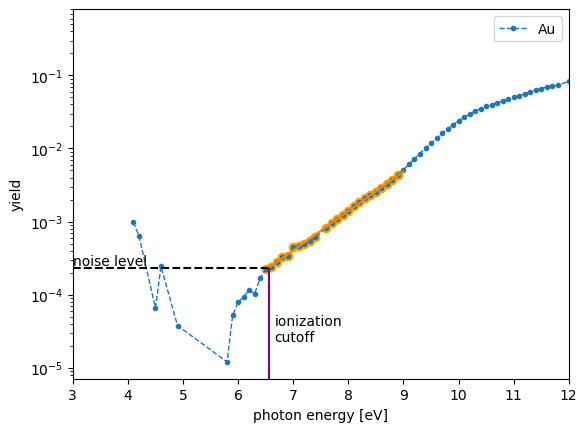

In [67]:
ion_cutoff(E_vals=Au_full_E, TEY_vals=Au_full_TEY,name='Au',start_eV=6.5,stop_eV=9)